-----------------------------------------------------------------------------
                             Python Script
-----------------------------------------------------------------------------
Author: Dr. Hyunglok Kim
Affiliation: School of Earth Sciences and Environmental Engineering,
             Gwangju Institute of Science and Technology (GIST)

Date: 2023

Version: 1.0

Course: EN5422/EV4238 - Applied Machine Learning for Environmental Data Analysis

-----------------------------------------------------------------------------
                            COPYRIGHT NOTICE
-----------------------------------------------------------------------------
© 2023 Dr. Hyunglok Kim, Gwangju Institute of Science and Technology.
All Rights Reserved.

Permission is granted to any individual or institution to use, copy, or
redistribute this software and documentation, under the following
conditions:

1. The software and documentation must not be distributed for profit,
   and must retain this copyright notice.

2. Any modifications to the software must be documented and those
   modifications must be released under the same terms as this license.

3. This software and documentation is provided "as is". The author(s)
   disclaim all warranties, whether express or implied, including but
   not limited to implied warranties of merchantability and fitness
   for a particular purpose.

-----------------------------------------------------------------------------
                               DESCRIPTION
-----------------------------------------------------------------------------
This script is written as part of the teaching materials for the
EN5422/EV4238 course "Applied Machine Learning for Environmental Data Analysis"
at Gwangju Institute of Science and Technology (GIST).

For detailed usage, please refer to the accompanying documentation
or course materials.

For questions, feedback, or further information, please contact:

Dr. Hyunglok Kim
Email: hyunglokkim@gist.ac.kr

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Data
url = 'https://raw.githubusercontent.com/Hyunglok-Kim/EN5422_EV4238/main/ED-counts.csv'
df = pd.read_csv(url)
x = df['count'].values

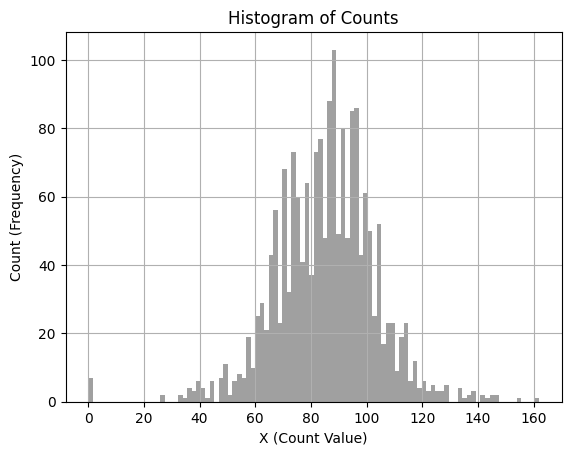

In [20]:
# Create a histogram
plt.hist(x, bins=100, alpha=0.75, color='grey')
plt.xlabel('X (Count Value)')
plt.ylabel('Count (Frequency)')
plt.title('Histogram of Counts')
plt.grid(True)
plt.show()

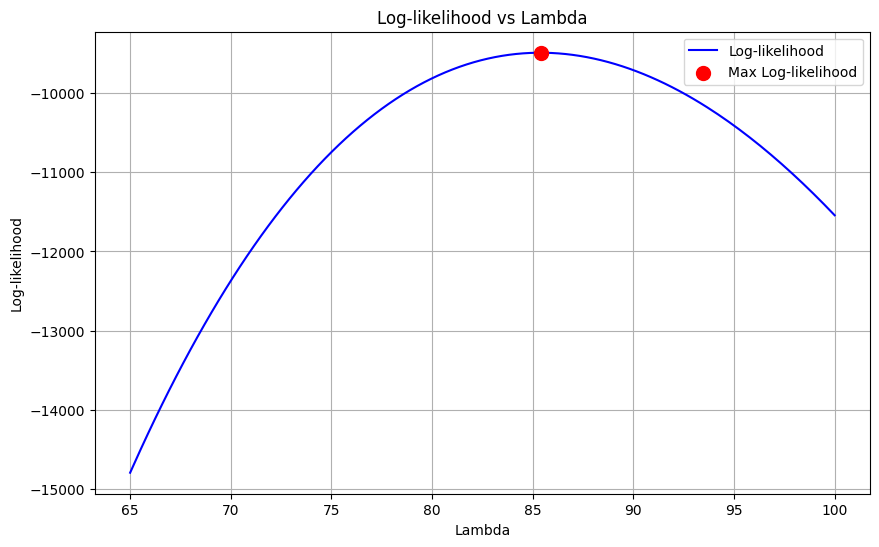

85.40201005025125


In [21]:
from scipy.stats import poisson

# Get sequence of lambda values
lam_seq = np.linspace(65, 100, 200)
nlam = len(lam_seq)

# Calculate the log-likelihood for those lambda values
loglike = np.array([np.sum(poisson.logpmf(x, mu=lam)) for lam in lam_seq])

# Find the lambda value that maximizes the log-likelihood
max_index = np.argmax(loglike)
best_lambda = lam_seq[max_index]
max_loglike = loglike[max_index]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(lam_seq, loglike, label='Log-likelihood', color='blue')
plt.scatter(best_lambda, max_loglike, color='red', s=100, zorder=5, label='Max Log-likelihood')  # Red dot marking the maximum
plt.xlabel('Lambda')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood vs Lambda')
plt.legend()
plt.grid(True)
plt.show()
print(best_lambda)

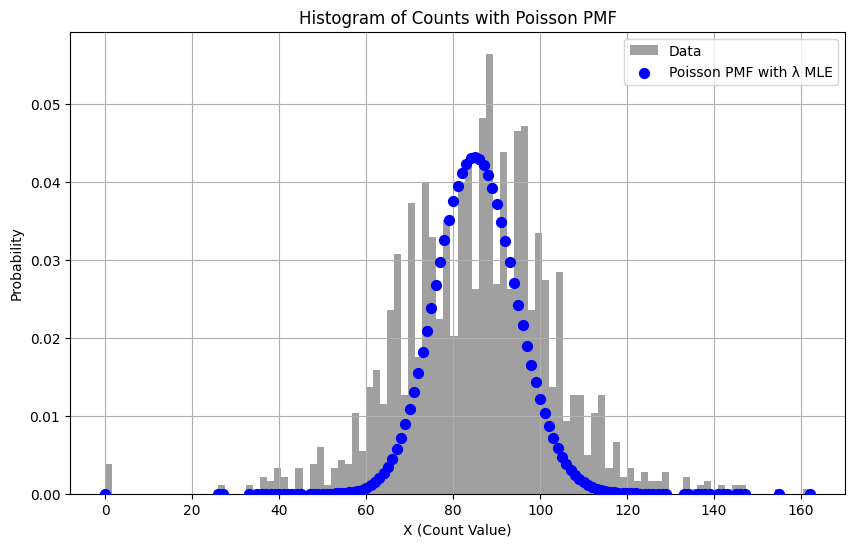

In [43]:
# 1. Plot the histogram with probability on the y-axis
plt.figure(figsize=(10, 6))
weights = np.ones_like(x) / len(x)  # This will convert counts to probabilities
plt.hist(x, bins=100, weights=weights, alpha=0.75, label='Data', color='grey')

# 2. Calculate the MLE for lambda
lambda_mle = np.mean(x)

# 3. Overlay the Poisson probabilities for a few data points using MLE of lambda
unique_values, counts = np.unique(x, return_counts=True)
poisson_probs = poisson.pmf(unique_values, lambda_mle)
plt.scatter(unique_values, poisson_probs, color='blue', s=50, zorder=5, label='Poisson PMF with λ MLE')

plt.xlabel('X (Count Value)')
plt.ylabel('Probability')
plt.title('Histogram of Counts with Poisson PMF')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import statsmodels.api as sm

# Assuming 'x' has been loaded from the CSV as before

# Fit the Poisson model
poisson_model = sm.GLM(np.asarray(x), np.ones_like(x), family=sm.families.Poisson()).fit()

# Get the coefficient (which is equivalent to the lambda in the Poisson distribution)
lambda_value = np.exp(poisson_model.params[0])

print(f'lambda: {lambda_value:.2f}')

lambda: 85.38


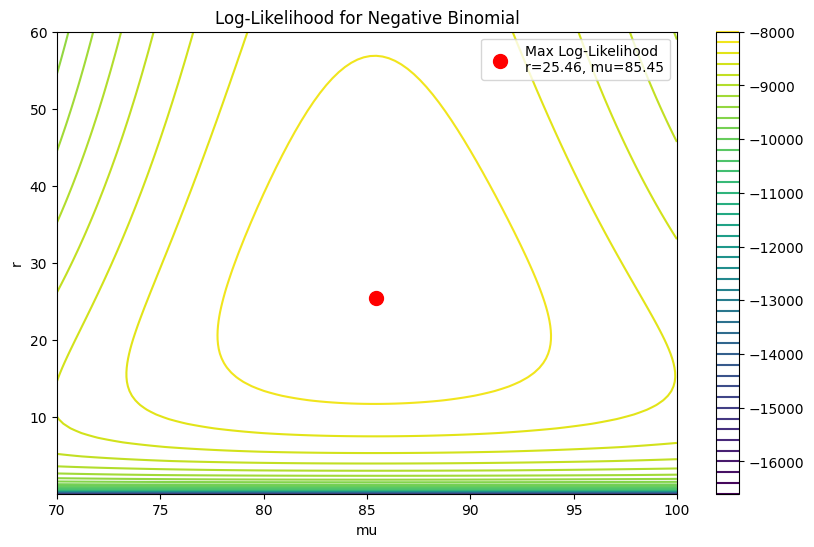

In [26]:
from scipy.stats import nbinom

# Define the log-likelihood for the negative binomial
def nb_loglike(params, data):
    r, mu = params
    # Convert mu (mean) to probability of success parameter for nbinom.pmf
    p = r / (r + mu)
    return np.sum(nbinom.logpmf(data, r, p))

# Grid of values for r and mu
r_values = np.linspace(0.01, 60, 100)  # Avoid r=0 to prevent division by zero or log of zero errors
mu_values = np.linspace(70, 100, 100)

# Calculate the log-likelihood for each combination
loglike_matrix = np.zeros((len(r_values), len(mu_values)))
for i, r in enumerate(r_values):
    for j, mu in enumerate(mu_values):
        loglike_matrix[i, j] = nb_loglike((r, mu), x)

# Find the indices of the maximum log-likelihood
max_r_idx, max_mu_idx = np.unravel_index(np.argmax(loglike_matrix), loglike_matrix.shape)
max_r = r_values[max_r_idx]
max_mu = mu_values[max_mu_idx]

# Plotting the contour
plt.figure(figsize=(10, 6))
contour = plt.contour(mu_values, r_values, loglike_matrix, levels=50)
plt.colorbar(contour)
plt.scatter(max_mu, max_r, color='red', s=100, zorder=5, label=f'Max Log-Likelihood\nr={max_r:.2f}, mu={max_mu:.2f}')
plt.title('Log-Likelihood for Negative Binomial')
plt.xlabel('mu')
plt.ylabel('r')
plt.legend()
plt.show()

In [32]:
from scipy.stats import nbinom
from scipy.optimize import minimize

# Function to compute negative log-likelihood for Negative Binomial
def nll(params, data):
    r, log_mu = params
    mu = np.exp(log_mu)  # We optimize in the log space for mu for stability
    prob = r / (r + mu)
    ll = nbinom.logpmf(data, r, prob)
    return -ll.sum()

# Initial guess
init_params = [10, np.log(np.mean(x))]

# Minimize the negative log-likelihood
result = minimize(nll, init_params, args=(x), bounds=((0.01, 1000), (np.log(1), np.log(200))))

r_mle, log_mu_mle = result.x
mu_mle = np.exp(log_mu_mle)

print(f"MLE for size (r): {r_mle:.2f}")
print(f"MLE for mu: {mu_mle:.2f}")


MLE for size (r): 25.63
MLE for mu: 85.38


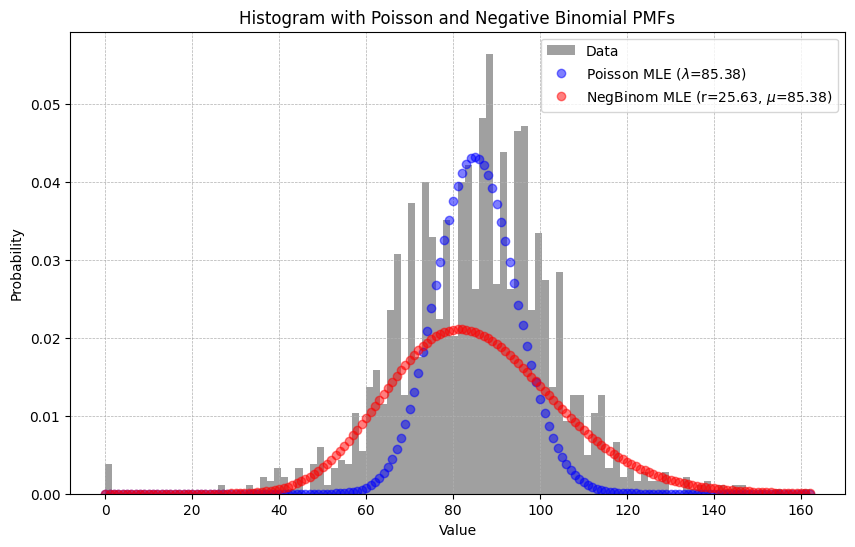

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom

# Assuming x has been loaded and you've calculated the following parameters:
# mu_mle (from the Poisson MLE)
# r_mle and mu_mle (from the Negative Binomial MLE)

plt.figure(figsize=(10, 6))
# Histogram
weights = np.ones_like(x) / len(x)  # This will convert counts to probabilities
plt.hist(x, bins=100, weights=weights, alpha=0.75, label='Data', color='grey')

# Poisson PMF
lambda_mle = np.mean(x)
x_vals_poisson = np.arange(0, x.max() + 1)
y_vals_poisson = poisson.pmf(x_vals_poisson, lambda_mle)
plt.plot(x_vals_poisson, y_vals_poisson, 'o', label=f'Poisson MLE ($\lambda$={lambda_mle:.2f})', color='blue', alpha=0.5)

# Negative Binomial PMF
prob_mle = r_mle / (r_mle + mu_mle)
x_vals_nb = np.arange(0, x.max() + 1)
y_vals_nb = nbinom.pmf(x_vals_nb, r_mle, prob_mle)
plt.plot(x_vals_nb, y_vals_nb, 'o', label=f'NegBinom MLE (r={r_mle:.2f}, $\mu$={mu_mle:.2f})', color='red', alpha=0.5)

plt.title("Histogram with Poisson and Negative Binomial PMFs")
plt.xlabel("Value")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


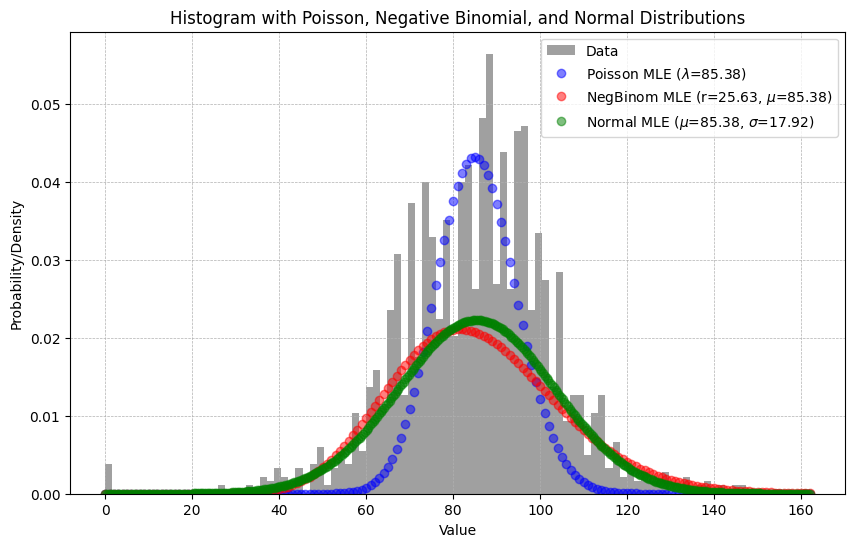

In [52]:
from scipy.stats import poisson, nbinom, norm

plt.figure(figsize=(10, 6))
# Histogram
weights = np.ones_like(x) / len(x)  # This will convert counts to probabilities
plt.hist(x, bins=100, weights=weights, alpha=0.75, label='Data', color='grey')

# Poisson PMF
lambda_mle = np.mean(x)
x_vals_poisson = np.arange(0, x.max() + 1)
y_vals_poisson = poisson.pmf(x_vals_poisson, lambda_mle)
plt.plot(x_vals_poisson, y_vals_poisson, 'o', label=f'Poisson MLE ($\lambda$={lambda_mle:.2f})', color='blue', alpha=0.5)

# Negative Binomial PMF
prob_mle = r_mle / (r_mle + mu_mle)
x_vals_nb = np.arange(0, x.max() + 1)
y_vals_nb = nbinom.pmf(x_vals_nb, r_mle, prob_mle)
plt.plot(x_vals_nb, y_vals_nb, 'o', label=f'NegBinom MLE (r={r_mle:.2f}, $\mu$={mu_mle:.2f})', color='red', alpha=0.5)

# Normal PDF with MLE parameters
mu_normal_mle = np.mean(x)
sigma_normal_mle = np.std(x)
x_vals_normal = np.linspace(x.min(), x.max(), 400)
y_vals_normal = norm.pdf(x_vals_normal, mu_normal_mle, sigma_normal_mle)
plt.plot(x_vals_normal, y_vals_normal, 'o', label=f'Normal MLE ($\mu$={mu_normal_mle:.2f}, $\sigma$={sigma_normal_mle:.2f})', color='green', alpha=0.5)

plt.title("Histogram with Poisson, Negative Binomial, and Normal Distributions")
plt.xlabel("Value")
plt.ylabel("Probability/Density")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [54]:
import statsmodels.api as sm
import numpy as np

# Load the Old Faithful data
faithful_dataset = sm.datasets.get_rdataset("faithful", "datasets")
faithful_data = faithful_dataset.data
wait = faithful_data['waiting'].values

# Calculate summary stats
sample_size = len(wait)
print(f"Sample size: {sample_size}")

# Six number summary
min_wait = np.min(wait)
max_wait = np.max(wait)
q1 = np.percentile(wait, 25)
q3 = np.percentile(wait, 75)
median_wait = np.median(wait)
mean_wait = np.mean(wait)

print(f"Min.: {min_wait}\n1st Qu.: {q1}\nMedian: {median_wait}\nMean: {mean_wait}\n3rd Qu.: {q3}\nMax.: {max_wait}")

# Mean
print(f"Mean: {mean_wait:.2f}")

# Standard deviation
std_dev = np.std(wait)
print(f"Standard Deviation: {std_dev:.2f}")

# Median
print(f"Median: {median_wait:.2f}")

# Quantiles
print(f"Quantiles:\n25%: {q1}\n50%: {median_wait}\n75%: {q3}")


Sample size: 272
Min.: 43
1st Qu.: 58.0
Median: 76.0
Mean: 70.8970588235294
3rd Qu.: 82.0
Max.: 96
Mean: 70.90
Standard Deviation: 13.57
Median: 76.00
Quantiles:
25%: 58.0
50%: 76.0
75%: 82.0


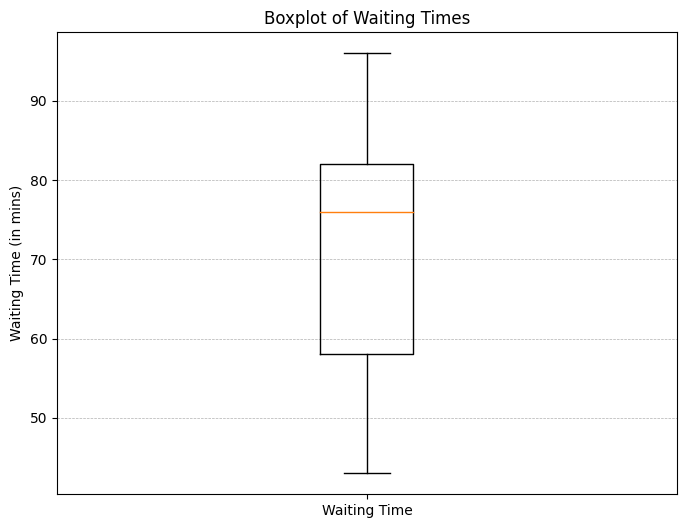

In [55]:
import matplotlib.pyplot as plt

# Boxplot for waiting times
plt.figure(figsize=(8, 6))
plt.boxplot(wait)
plt.title("Boxplot of Waiting Times")
plt.ylabel("Waiting Time (in mins)")
plt.xticks([1], ['Waiting Time'])
plt.grid(True, which="both", linestyle="--", linewidth=0.5, axis='y')
plt.show()


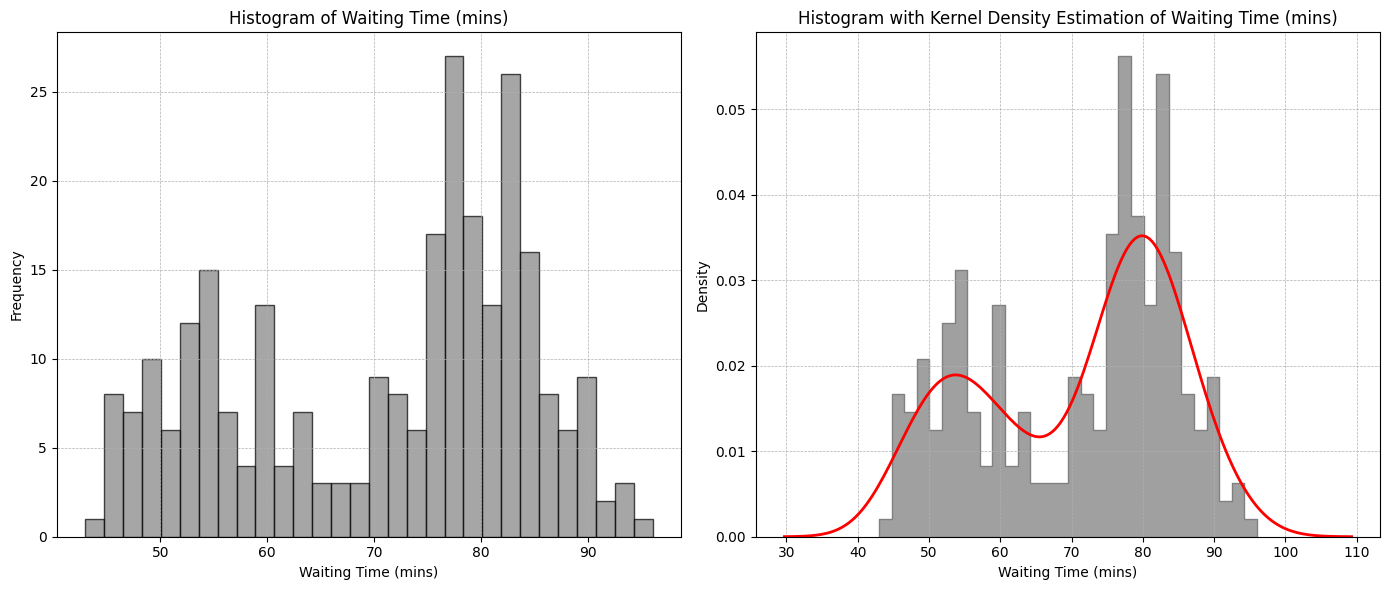

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setup the 1x2 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Histogram for 'waiting time' on subplot (1,1)
axes[0].hist(wait, bins=30, alpha=0.7, color='grey', edgecolor='black')
axes[0].set_title("Histogram of Waiting Time (mins)")
axes[0].set_xlabel("Waiting Time (mins)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# Overlaid histogram for 'waiting time' on subplot (1,2)
sns.histplot(wait, ax=axes[1], bins=30, color='grey', element="step", stat="density", common_norm=False)
sns.kdeplot(wait, ax=axes[1], color="red", lw=2)
axes[1].set_title("Histogram with Kernel Density Estimation of Waiting Time (mins)")
axes[1].set_xlabel("Waiting Time (mins)")
axes[1].set_ylabel("Density")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust the layout
plt.tight_layout()
plt.show()

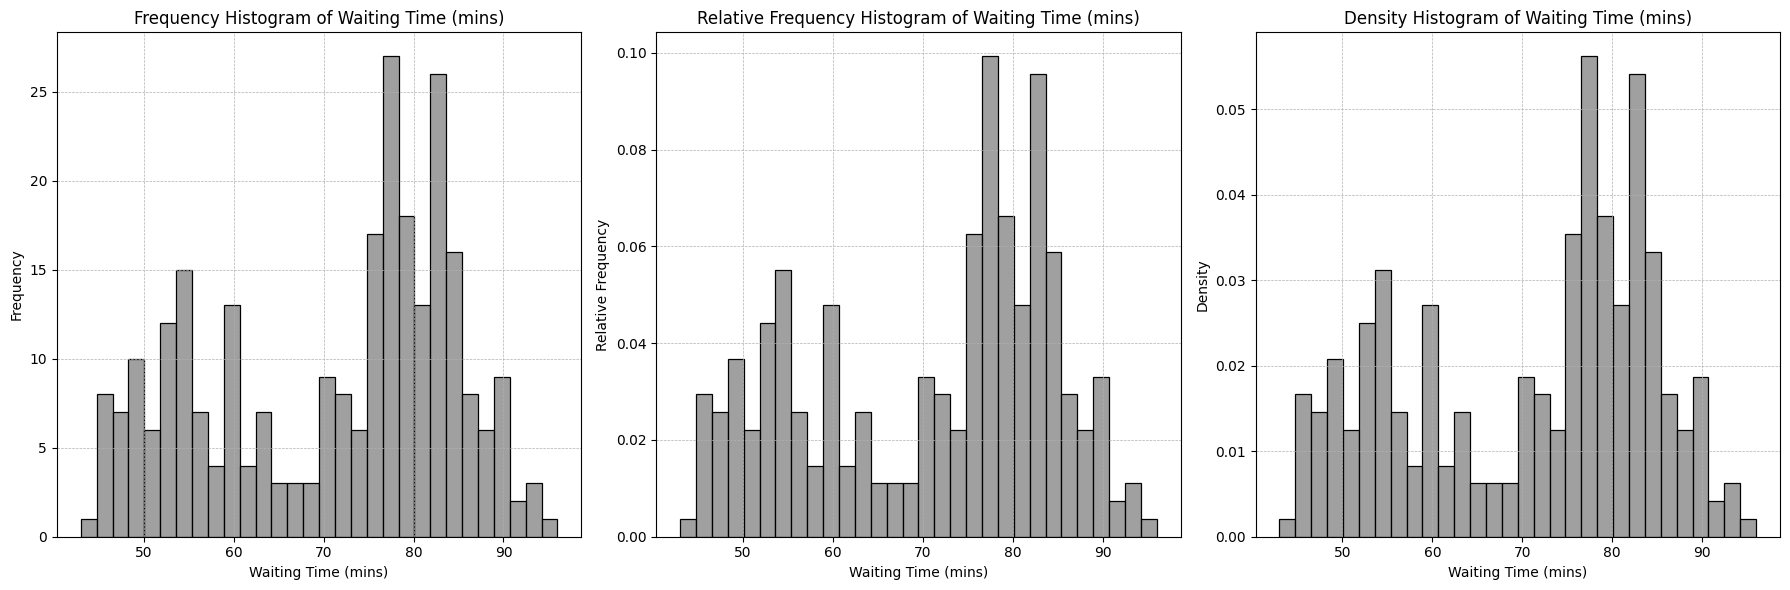

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setup the 1x3 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Frequency Histogram
sns.histplot(wait, ax=axes[0], bins=30, color='grey', edgecolor='black', kde=False)
axes[0].set_title("Frequency Histogram of Waiting Time (mins)")
axes[0].set_xlabel("Waiting Time (mins)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# Relative Frequency Histogram
sns.histplot(wait, ax=axes[1], bins=30, color='grey', edgecolor='black', kde=False, stat="probability")
axes[1].set_title("Relative Frequency Histogram of Waiting Time (mins)")
axes[1].set_xlabel("Waiting Time (mins)")
axes[1].set_ylabel("Relative Frequency")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

# Density Histogram with KDE
sns.histplot(wait, ax=axes[2], bins=30, color='grey', edgecolor='black', stat="density")
axes[2].set_title("Density Histogram of Waiting Time (mins)")
axes[2].set_xlabel("Waiting Time (mins)")
axes[2].set_ylabel("Density")
axes[2].grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust the layout
plt.tight_layout()
plt.show()


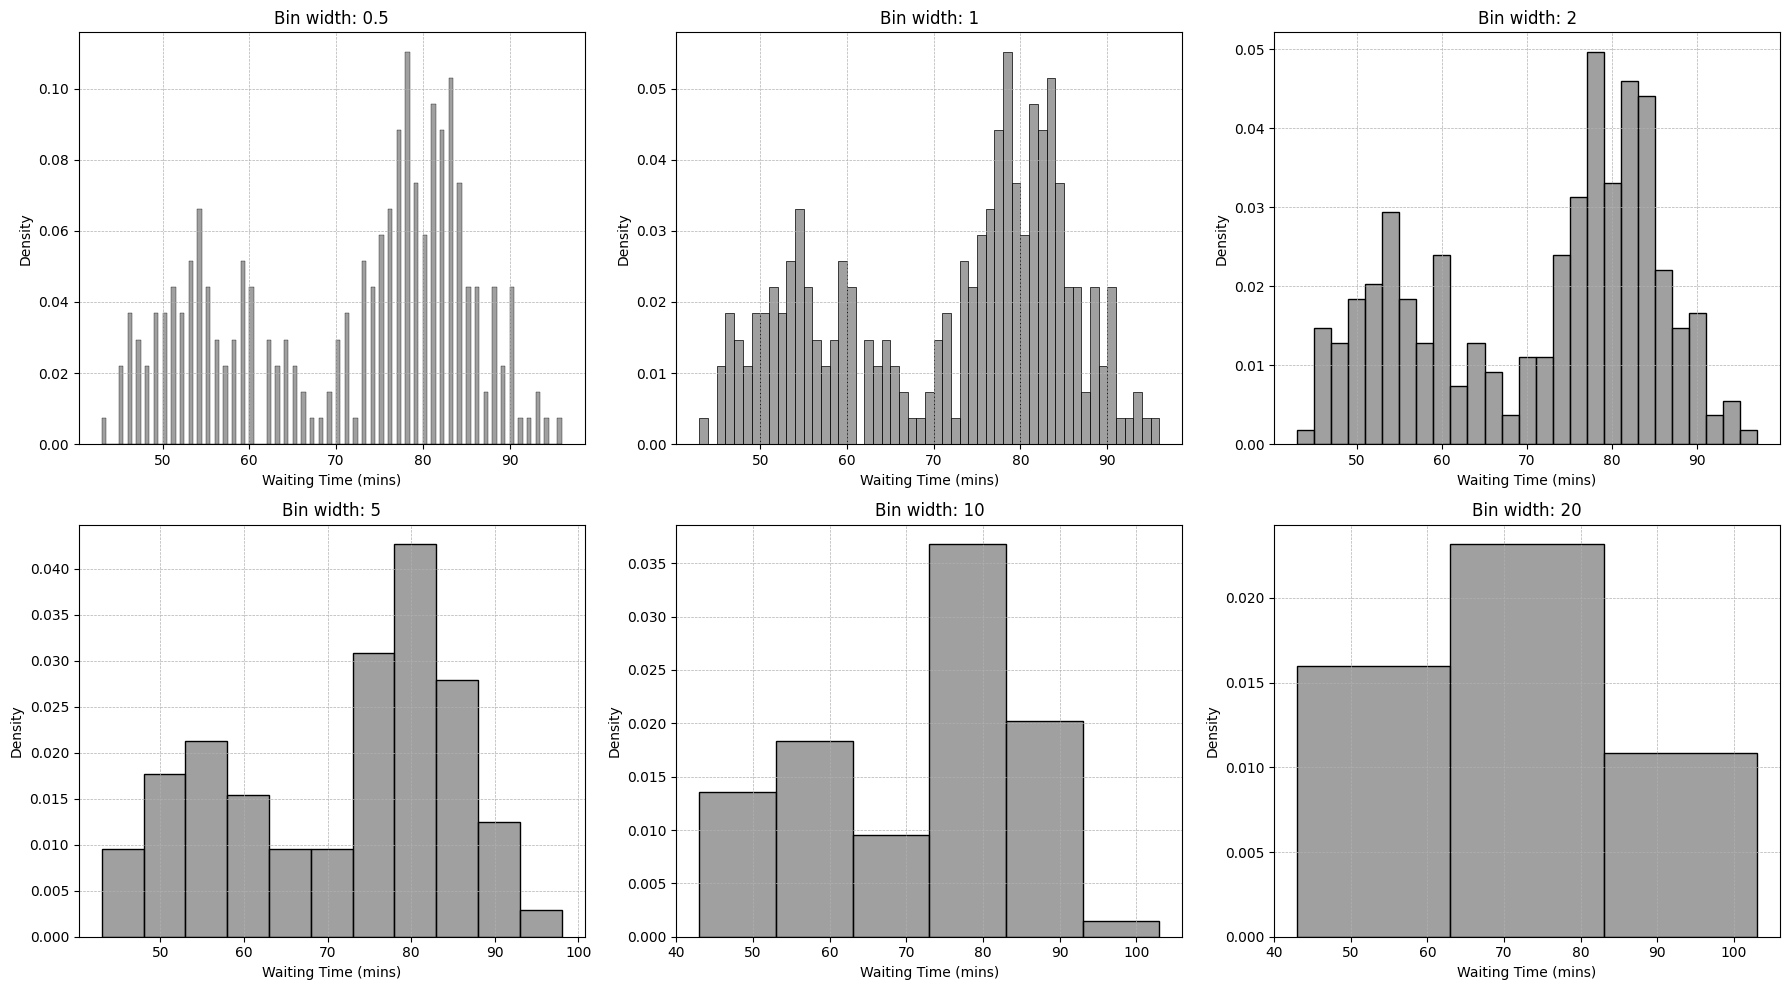

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Bin widths to consider
bin_widths = [0.5, 1, 2, 5, 10, 20]
bins_list = [np.arange(min(wait), max(wait) + bw, bw) for bw in bin_widths]

# Setup the 2x3 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Iterate over the axes and bins to plot each histogram
for ax, bins in zip(axes.ravel(), bins_list):
    sns.histplot(wait, ax=ax, bins=bins, color='grey', edgecolor='black', stat="density")
    ax.set_title(f"Bin width: {bins[1]-bins[0]}")
    ax.set_xlabel("Waiting Time (mins)")
    ax.set_ylabel("Density")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust the layout
plt.tight_layout()
plt.show()


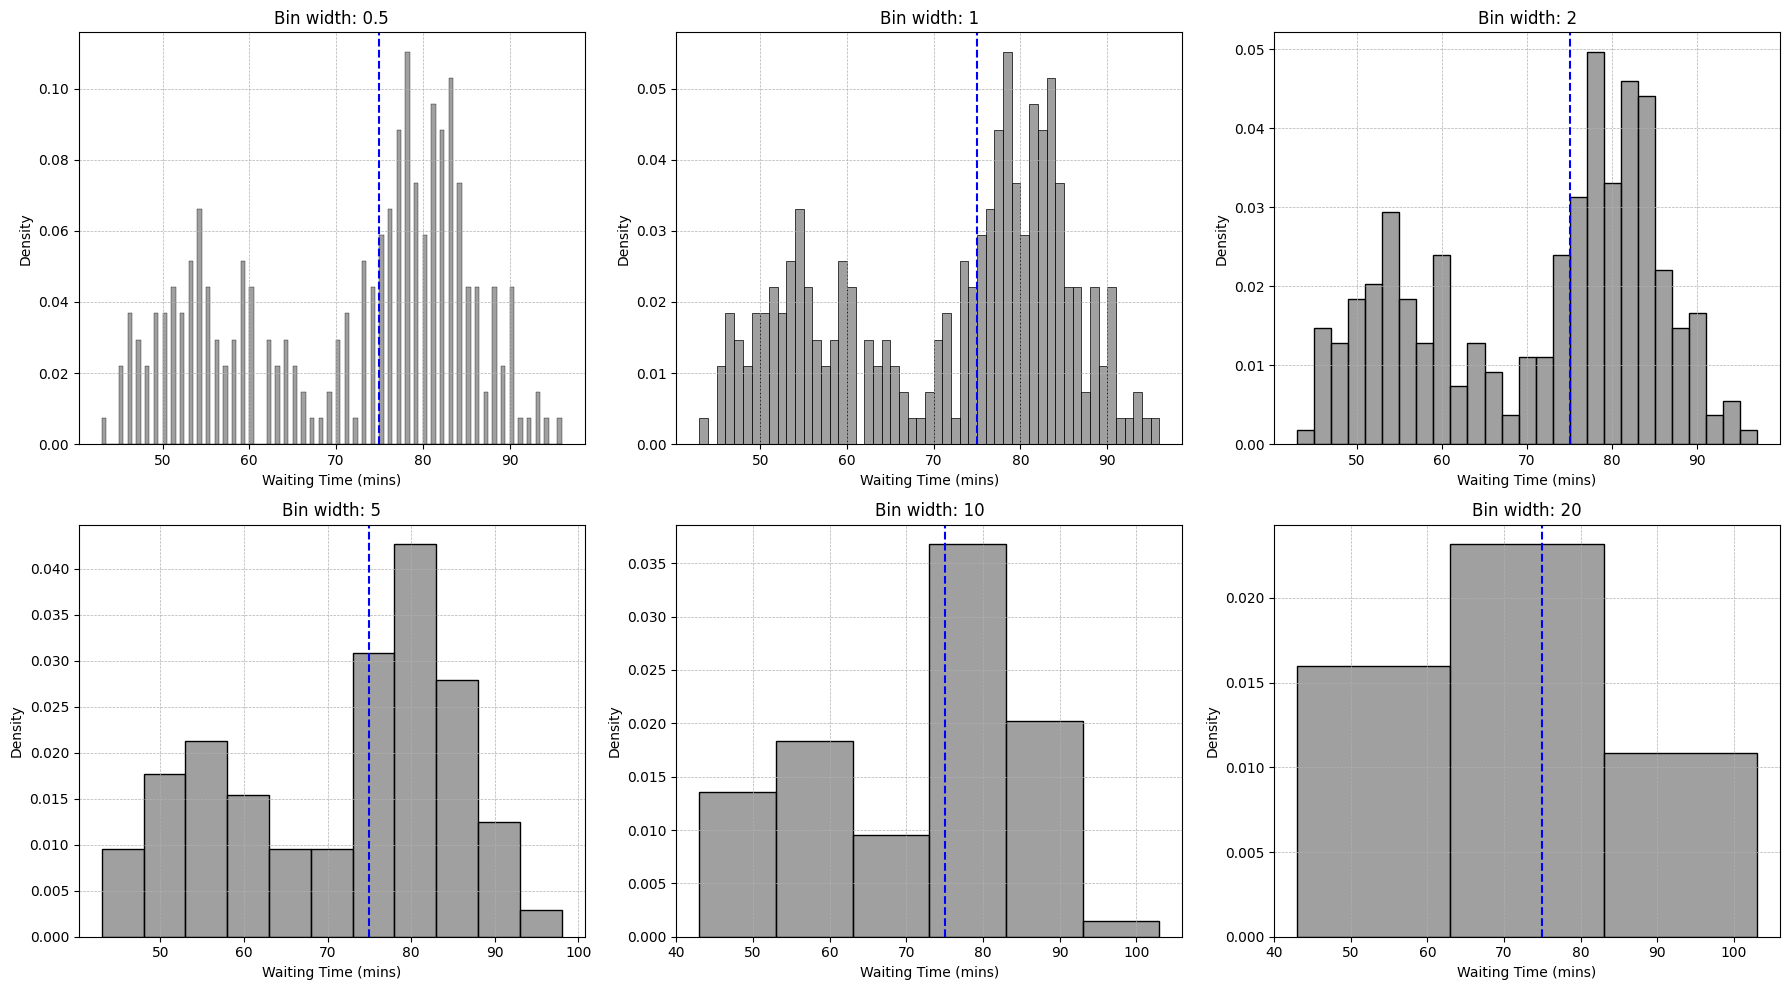

In [72]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Bin widths to consider
bin_widths = [0.5, 1, 2, 5, 10, 20]
bins_list = [np.arange(min(wait), max(wait) + bw, bw) for bw in bin_widths]

# Setup the 2x3 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Iterate over the axes and bins to plot each histogram
for ax, bins in zip(axes.ravel(), bins_list):
    sns.histplot(wait, ax=ax, bins=bins, color='grey', edgecolor='black', stat="density")
    ax.axvline(75, color='blue', linestyle='--', linewidth=1.5)
    ax.set_title(f"Bin width: {bins[1]-bins[0]}")
    ax.set_xlabel("Waiting Time (mins)")
    ax.set_ylabel("Density")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust the layout
plt.tight_layout()
plt.show()


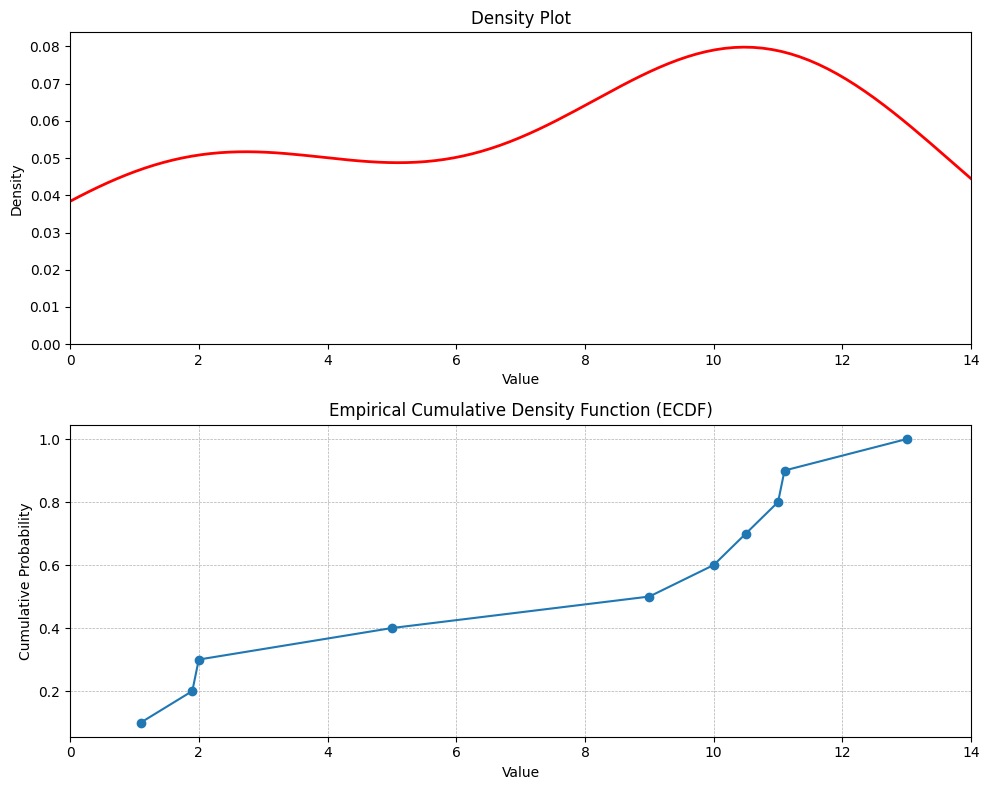

In [73]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Dataset
D = [1.1, 1.9, 2, 5, 9, 10, 10.5, 11, 11.1, 13]

# Set up the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Density plot
sns.kdeplot(D, ax=ax[0], color='red', lw=2)
ax[0].set_title("Density Plot")
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Density")
ax[0].set_xlim([0, 14])

# ECDF
ecdf = ECDF(D)
ax[1].plot(ecdf.x, ecdf.y, marker='o', linestyle='-')
ax[1].set_title("Empirical Cumulative Density Function (ECDF)")
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Cumulative Probability")
ax[1].set_xlim([0, 14])
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


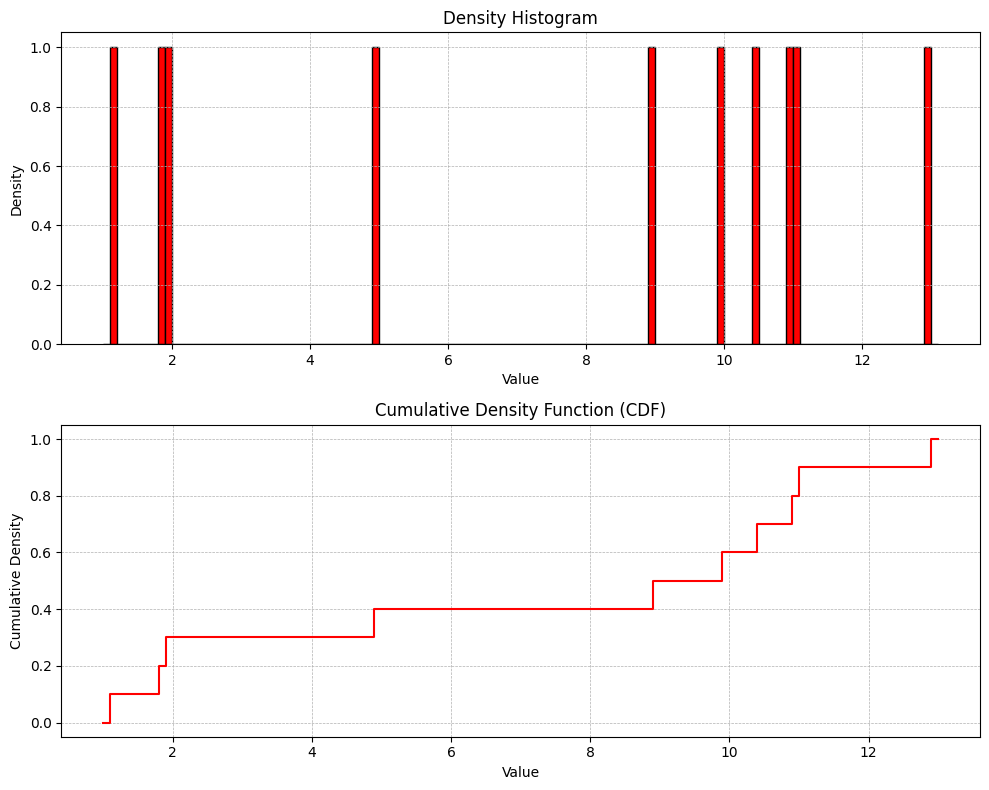

In [75]:
# Dataset
D = [1.1, 1.9, 2, 5, 9, 10, 10.5, 11, 11.1, 13]

# Plot settings
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
bin_width = 0.1
bins = np.arange(min(D) - bin_width, max(D) + 2*bin_width, bin_width)

# Histogram for density
hist, edges = np.histogram(D, bins=bins, density=True)
axes[0].bar(edges[:-1], hist, width=np.diff(edges), align="edge", color='red', edgecolor='black')
axes[0].set_title("Density Histogram")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Density")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# Histogram for cumulative density
hist_cdf, edges_cdf = np.histogram(D, bins=bins, density=True)
cdf = np.cumsum(hist_cdf) * bin_width  # Calculate the cumulative sum
axes[1].plot(edges_cdf[:-1], cdf, drawstyle="steps-post", color='red', label='CDF')
axes[1].set_title("Cumulative Density Function (CDF)")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Cumulative Density")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

# Display plot
plt.tight_layout()
plt.show()


In [79]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import imageio

D = [1.1, 1.9, 2, 5, 9, 10, 10.5, 11, 11.1, 13]

# Moving window (uniform kernel) estimator
def moving_window_uniform(x, data, h=1):
    N = len(data)
    count = sum([1 for xi in data if x - h/2 <= xi <= x + h/2])
    return count / (N * h)

x_range = np.arange(0, 14.1, 0.1)
duration = 0.2

frames_with_hist = []

for x in x_range:
    fig, ax = plt.subplots(figsize=(8,6))

    # Compute densities for all x using the moving window estimator
    densities = [moving_window_uniform(xi, D) for xi in x_range]

    # Explicit data histogram in red with value 0.1
    ax.hist(D, bins=np.arange(0.05, 14.15, 0.1), weights=[0.1]*len(D), color='red', alpha=0.6, label='Data Histogram')

    # Plot densities
    ax.plot(x_range, densities, color='blue', label='Estimated Density')

    # Red dashed line at the current x
    ax.axvline(x, color='red', linestyle='--')

    # Grey shaded box
    ax.axvspan(x - 0.5, x + 0.5, alpha=0.2, color='grey')

    ax.set_xlim([0, 14])
    ax.set_ylim([0, 0.5])
    ax.set_title(f'Moving Window at x={x:.1f}')
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Save frame
    frame_path = f'frame_with_hist_{int(10*x)}.png'
    plt.savefig(frame_path)
    frames_with_hist.append(frame_path)

    plt.close()

# Create the GIF with the new frames
imageio.mimsave('moving_window_with_hist.gif', [imageio.imread(frame) for frame in frames_with_hist], duration=duration)


<ipython-input-79-2a63053156fc>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave('moving_window_with_hist.gif', [imageio.imread(frame) for frame in frames_with_hist], duration=duration)


In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# The dataset
D = [1.1, 1.9, 2, 5, 9, 10, 10.5, 11, 11.1, 13]

# Kernel functions
def triangular_kernel(u):
    return 1 - abs(u) if abs(u) <= 1 else 0

def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

# Calculate density using the chosen kernel function
def evaluate_density(x, data, h, kernel_func):
    return sum([kernel_func((x - xi) / h) for xi in data]) / (len(data) * h)

# Function to generate the animated plot
def generate_gif(kernel_name, kernel_func, filename):
    fig, ax = plt.subplots(figsize=(8, 6))
    x = np.linspace(0, 14, 500)

    # Function to get kernel plot for current point
    def get_kernel_plot(xi, h, kernel_func):
        return [kernel_func((xi - xj) / h) for xj in x]

    def update(num, x, D, line, h, kernel_func):
        y = [evaluate_density(xi, D, h, kernel_func) for xi in x]
        line.set_ydata(y)
        ax.set_title(f"Density Estimation Using {kernel_name} Kernel - x={x[num]:.1f}")
        shaded_area.set_ydata(get_kernel_plot(x[num], h, kernel_func))
        return line, shaded_area

    y = [evaluate_density(xi, D, 1, kernel_func) for xi in x]
    line, = ax.plot(x, y, 'r-', animated=True)

    # Draw data histogram
    ax.hist(D, bins=np.arange(0.05, 14.15, 0.1), weights=[0.1]*len(D), color='red', alpha=0.6, label='Data Histogram')

    shaded_area, = ax.plot(x, get_kernel_plot(0, 1, kernel_func), 'grey', animated=True, alpha=0.4)

    ax.set_ylim(0, 0.5)

    ani = FuncAnimation(fig, update, frames=len(x), fargs=[x, D, line, 1, kernel_func], repeat=True)
    ani.save(filename, writer='imagemagick', fps=30)
    plt.close(fig)

generate_gif("Triangular", triangular_kernel, "triangular_kernel.gif")
generate_gif("Gaussian", gaussian_kernel, "gaussian_kernel.gif")

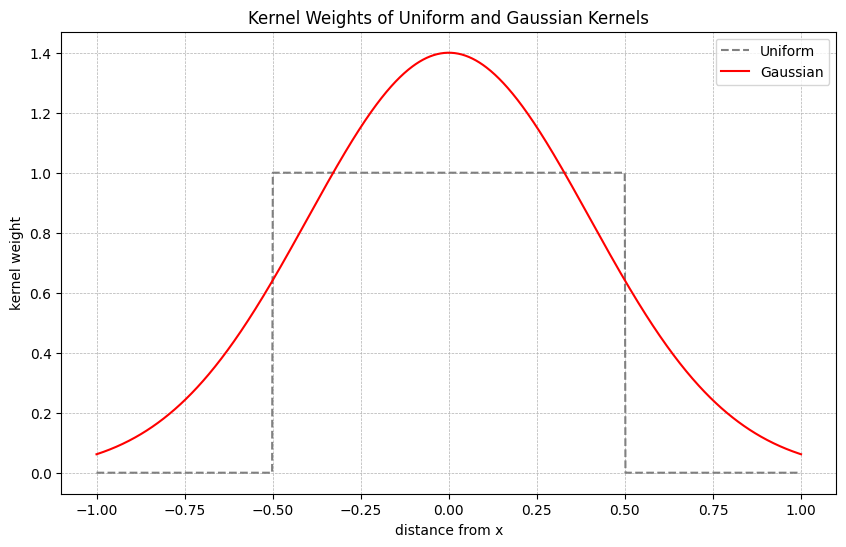

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the distance from x values
x_values = np.linspace(-1, 1, 1000)

# Defining the uniform and gaussian kernel functions
def uniform_kernel(x):
    return 1.0 if abs(x) <= 0.5 else 0.0

def gaussian_kernel(x):
    # Ensure that Gaussian kernel has a weight of 0 at x = -1 and x = 1
    # By transforming the domain to fit within the range where Gaussian has near-zero values
    transformed_x = 2.5 * x
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * transformed_x**2)

# Getting the kernel weights for the x_values
uniform_weights = [uniform_kernel(x) for x in x_values]
gaussian_weights = [gaussian_kernel(x) for x in x_values]

# Ensure Gaussian kernel has a weight of 1.4 at x = 0
max_gaussian_weight = max(gaussian_weights)
scaling_factor = 1.4 / max_gaussian_weight
gaussian_weights = [weight * scaling_factor for weight in gaussian_weights]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, uniform_weights, '--', label='Uniform', color='grey')
plt.plot(x_values, gaussian_weights, '-', label='Gaussian', color='red')
plt.legend()
plt.xlabel("distance from x")
plt.ylabel("kernel weight")
plt.title("Kernel Weights of Uniform and Gaussian Kernels")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



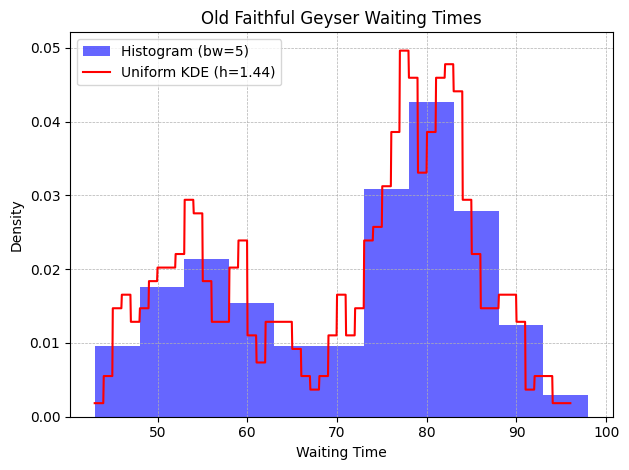

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import uniform

# Load the Old Faithful data
faithful_dataset = sm.datasets.get_rdataset("faithful", "datasets")
faithful_data = faithful_dataset.data
wait = faithful_data['waiting'].values

# Plot histogram
plt.hist(wait, bins=np.arange(min(wait), max(wait) + 5, 5), density=True, alpha=0.6, color='blue', label='Histogram (bw=5)')

# Uniform Kernel Density Estimate
h = 1.44  # bandwidth
x = np.linspace(min(wait), max(wait), 1000)
y = np.zeros_like(x)
for val in wait:
    y += uniform.pdf(x, loc=val-h/2, scale=h)

y /= len(wait)
plt.plot(x, y, 'r-', label='Uniform KDE (h=1.44)')

plt.xlabel('Waiting Time')
plt.ylabel('Density')
plt.title('Old Faithful Geyser Waiting Times')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

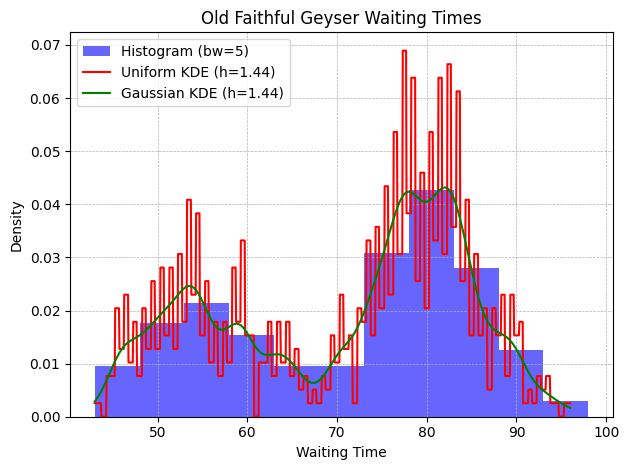

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import uniform, norm

# Load the Old Faithful data
faithful_dataset = sm.datasets.get_rdataset("faithful", "datasets")
faithful_data = faithful_dataset.data
wait = faithful_data['waiting'].values

# Plot histogram
plt.hist(wait, bins=np.arange(min(wait), max(wait) + 5, 5), density=True, alpha=0.6, color='blue', label='Histogram (bw=5)')

# Uniform Kernel Density Estimate
h = 1.44  # bandwidth
x = np.linspace(min(wait), max(wait), 1000)
y_uniform = np.zeros_like(x)
for val in wait:
    y_uniform += uniform.pdf(x, loc=val-h/2, scale=h)

y_uniform /= len(wait)
plt.plot(x, y_uniform, 'r-', label='Uniform KDE (h=1.44)')

# Gaussian Kernel Density Estimate
y_gaussian = np.zeros_like(x)
for val in wait:
    y_gaussian += norm.pdf(x, loc=val, scale=h)

y_gaussian /= len(wait)
plt.plot(x, y_gaussian, 'g-', label='Gaussian KDE (h=1.44)')

plt.xlabel('Waiting Time')
plt.ylabel('Density')
plt.title('Old Faithful Geyser Waiting Times')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

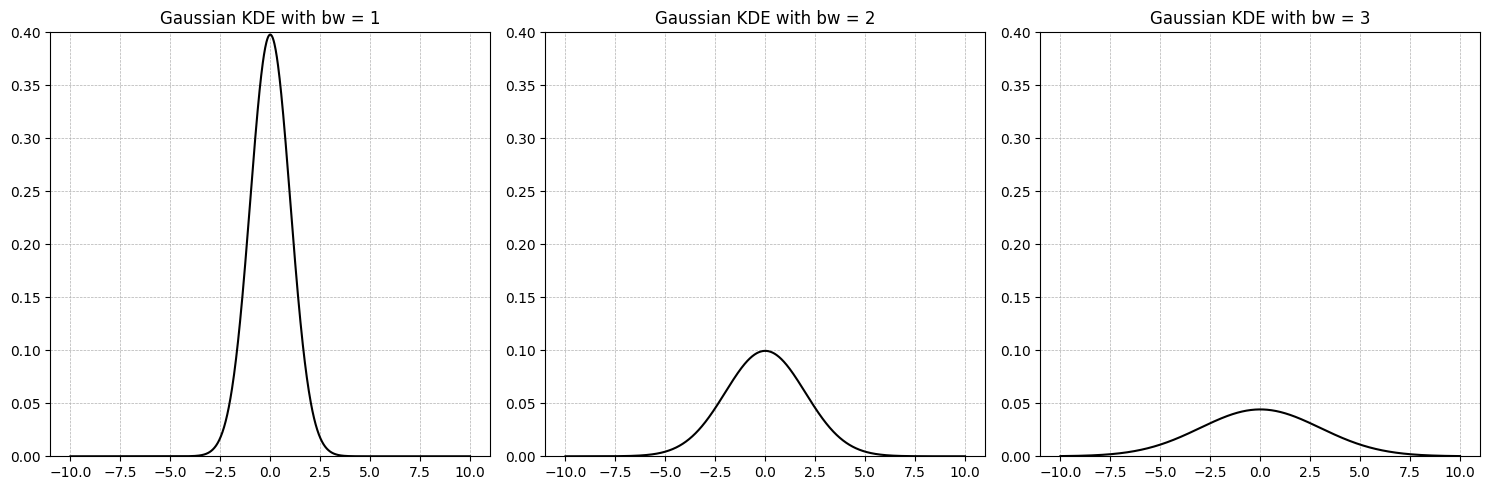

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Data range and mesh grid
x = np.linspace(-10, 10, 1000)

# Define function to get Gaussian KDE with given bw
def gaussian_kde(x, bw):
    # Given that the density is maximum 0.4 at x=0
    scale_factor = bw * np.sqrt(2 * np.pi) * 0.4
    return norm.pdf(x, scale=bw) / scale_factor

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for bw = 1
axs[0].plot(x, gaussian_kde(x, 1), 'k-')
axs[0].set_title('Gaussian KDE with bw = 1')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].set_ylim(0, 0.4)

# Plot for bw = 2
axs[1].plot(x, gaussian_kde(x, 2), 'k-')
axs[1].set_title('Gaussian KDE with bw = 2')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].set_ylim(0, 0.4)

# Plot for bw = 3
axs[2].plot(x, gaussian_kde(x, 3), 'k-')
axs[2].set_title('Gaussian KDE with bw = 3')
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[2].set_ylim(0, 0.4)

# Display plot
plt.tight_layout()
plt.show()

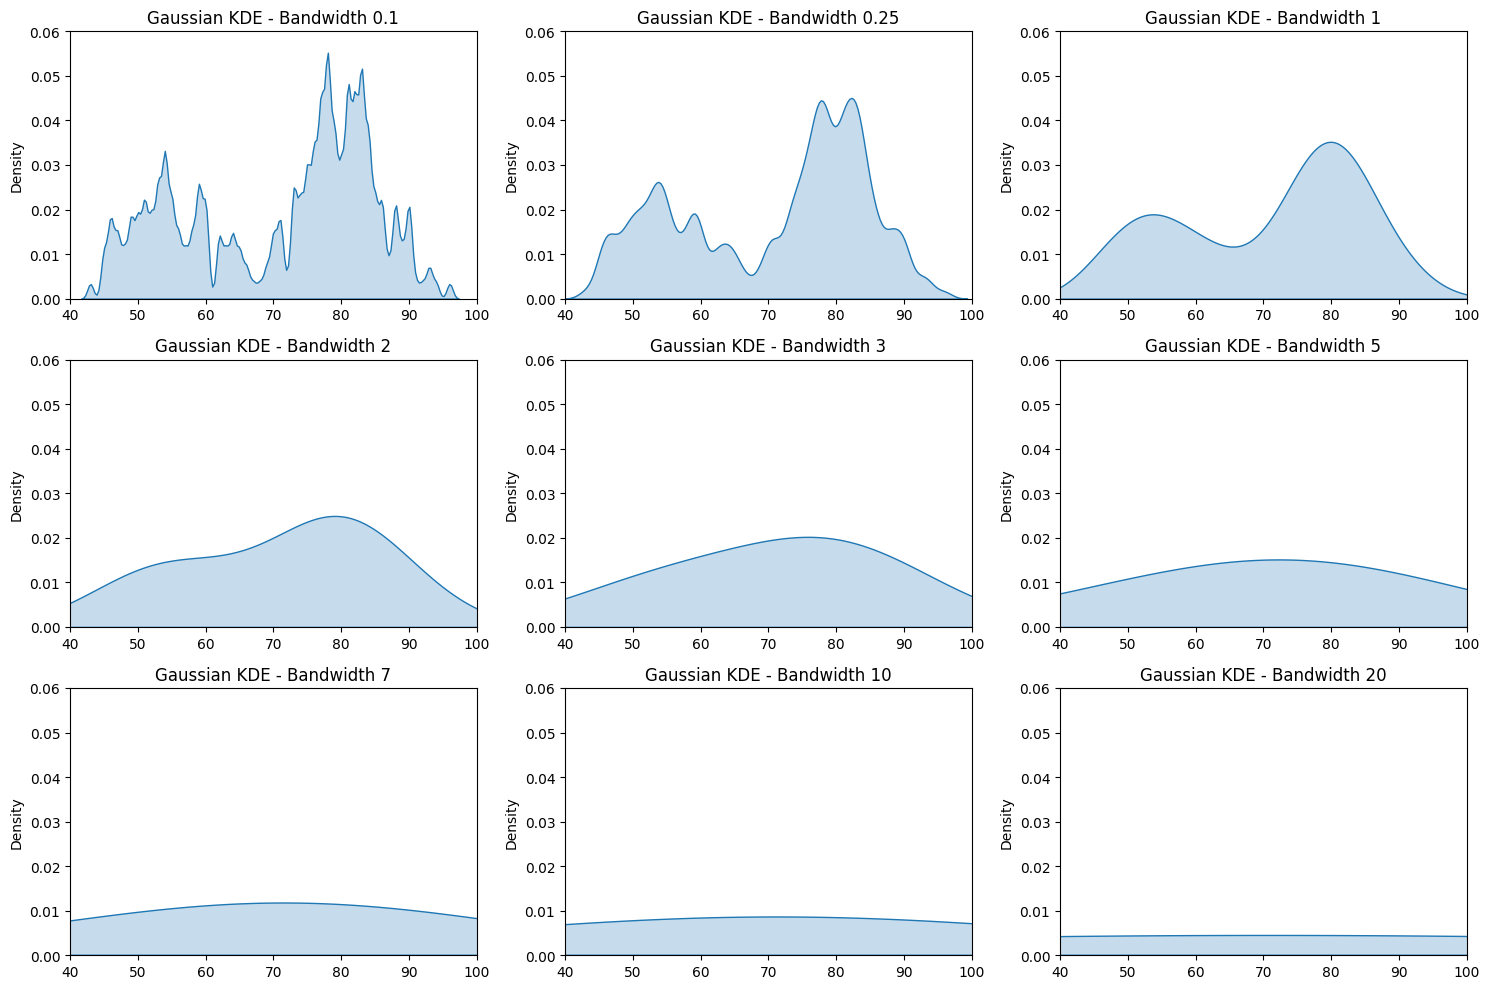

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load the Old Faithful data
faithful_dataset = sm.datasets.get_rdataset("faithful", "datasets")
faithful_data = faithful_dataset.data
wait = faithful_data['waiting'].values

bandwidths = [0.1, 0.25, 1, 2, 3, 5, 7, 10, 20]
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, bw in zip(axes.ravel(), bandwidths):
    sns.kdeplot(wait, bw_adjust=bw, ax=ax, fill=True)
    ax.set_title(f"Gaussian KDE - Bandwidth {bw}")
    ax.set_xlim([40, 100])
    ax.set_ylim([0, 0.06])

plt.tight_layout()
plt.show()

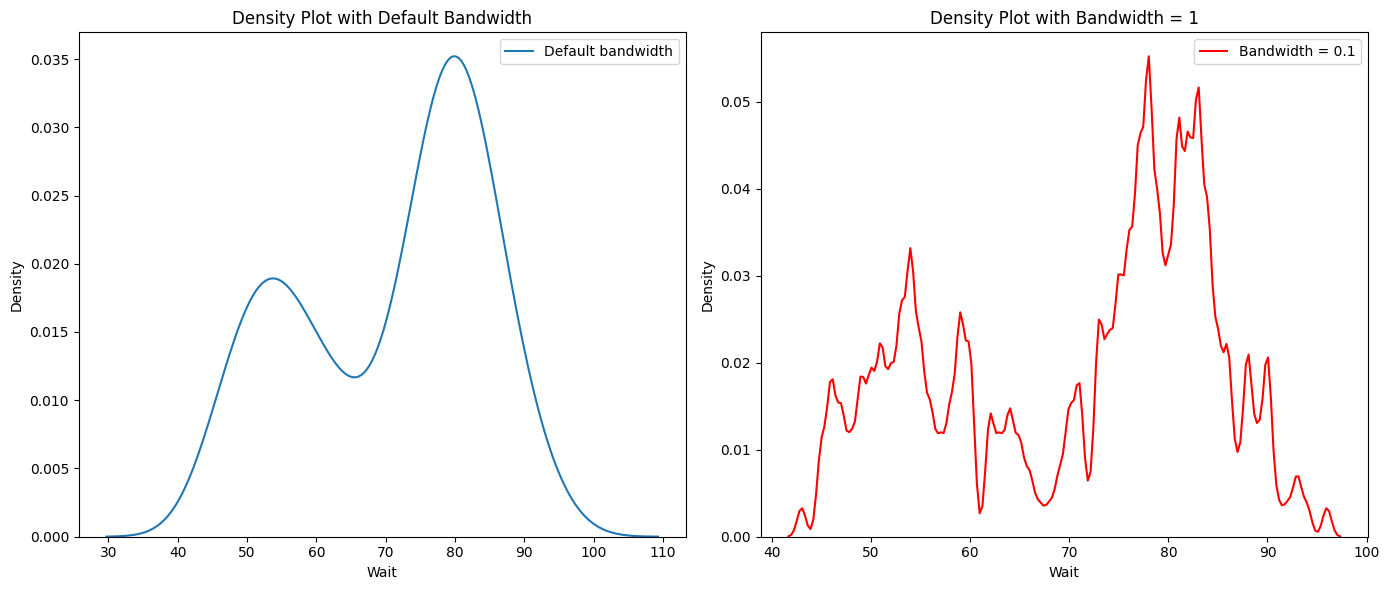

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Old Faithful data
faithful_dataset = sm.datasets.get_rdataset("faithful", "datasets")
faithful_data = faithful_dataset.data
wait = faithful_data['waiting'].values

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Default bandwidth (smoother KDE)
sns.kdeplot(wait, ax=axes[0], label="Default bandwidth")
axes[0].set_title("Density Plot with Default Bandwidth")
axes[0].set_xlabel("Wait")
axes[0].set_ylabel("Density")
axes[0].legend()

# Subplot 2: Specified bandwidth of 1 (less smooth)
sns.kdeplot(wait, bw_adjust=0.1, color="red", ax=axes[1], label="Bandwidth = 0.1")
axes[1].set_title("Density Plot with Bandwidth = 1")
axes[1].set_xlabel("Wait")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()

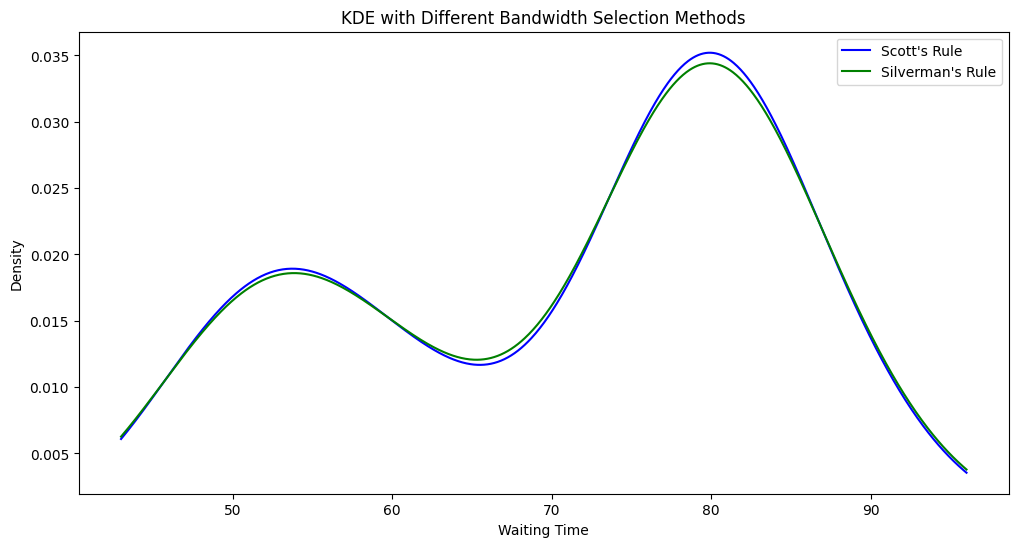

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.api as sm

# Load the Old Faithful data
faithful_dataset = sm.datasets.get_rdataset("faithful", "datasets")
faithful_data = faithful_dataset.data
wait = faithful_data['waiting'].values

# Kernel density estimation using Scott's rule
kde_scott = gaussian_kde(wait, bw_method='scott')

# Kernel density estimation using Silverman's rule
kde_silverman = gaussian_kde(wait, bw_method='silverman')

# Plot
x = np.linspace(wait.min(), wait.max(), 1000)
plt.figure(figsize=(12, 6))
plt.plot(x, kde_scott(x), label="Scott's Rule", color='blue')
plt.plot(x, kde_silverman(x), label="Silverman's Rule", color='green')
plt.legend()
plt.title('KDE with Different Bandwidth Selection Methods')
plt.xlabel('Waiting Time')
plt.ylabel('Density')
plt.show()
